In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data as data
import torch
import PIL
import numpy as np
from tqdm import tqdm
from IPython import display
import cv2
import matplotlib.pyplot as plt

<h1>Pre-load faces</h1>

In [2]:
import os
import collections

<h2>Load faces in a video</h2>

In [5]:
def loadFaces(face_directory):
    faces = collections.defaultdict(list)
#     faces are loaded as dict of <identity> : <list of picture directories>
    identities = os.listdir(face_directory)
    for identity in identities:
        faces[identity] = os.listdir(face_directory + "/" + identity)
    return faces

def loadFacesMultiVideo(face_directory):
    faces = collections.defaultdict(list)
#     faces are loaded as dict of <identity> : <list of picture directories>
    folders = os.listdir(face_directory)
    for folder in folders:
        identities = os.listdir(face_directory + folder + "/")
        for identity in identities:
            face_path = face_directory + folder + "/"
            faces[identity]+= [face_path  + identity 
                               + "/" + file_name for file_name in (os.listdir(face_path + identity))]
    return faces

# loadFaces("/home/bone/Projects/face/secondTermExperiment/videos/classvid-processed/classvid1/processed-classvid1-2-version-0/")
faces = loadFacesMultiVideo("/home/bone/Projects/face/secondTermExperiment/videos/classvid-processed/classvid1/")

In [6]:
min_amount = 10000
max_amount = 0
for identity in faces:
    min_amount = min(min_amount, len(faces[identity]))
    max_amount = max(max_amount, len(faces[identity]))
print("min amount: ", min_amount)
print("max amount: ", max_amount)

min amount:  8
max amount:  92


<h2>Load profile faces</h2>

In [7]:
import sys
sys.path.insert(0, "/home/bone/Projects/face/secondTermExperiment/alignment")
from getMultiAlignment import MultifaceAlignment
                
def loadProfile(directory, faces):
    profiles = {}
    files = os.listdir(directory)
    ma = MultifaceAlignment()
    for file in files:
        identity = file[:-4]
        if identity not in faces and (not file.endswith(".jpg") or not file.endswith(".png")):
            continue
        face = cv2.imread(directory + "/" + file)
        face = ma.getAlignments(face, mode="alignedFaces")[0]
        profiles[identity] = face
    return profiles
profiles = loadProfile("/home/bone/Projects/face/secondTermExperiment/videos/classvid-faces/classvid1", faces)

In [53]:
# display.set_matplotlib_formats('svg')
# _, figs = plt.subplots(1, len(profiles), figsize=(20, 10))
# counter = 0
# for f,face_profile in zip(figs, profiles):
#     counter += 1
#     face = cv2.cvtColor(cv2.resize(profiles[face_profile],(112,112)),cv2.COLOR_BGR2RGB)
#     f.imshow(face)
#     ax = f.axes
#     ax.title.set_fontsize(14)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()
    
        

In [9]:
import random
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((112, 112)),
    torchvision.transforms.ToTensor()
])

class TestSet(data.Dataset):
    def __init__(self, faces, amount = 1000, train=False, transform=transforms):
        amount = amount
        self.faces = faces
        self.transforms = transform
        self.identities = []
        for face in faces:
            self.identities.append(face)
        self.dataset = []
        self.labels = []
        false_amount = amount//2
        true_count = 0
        false_count = 0
        for i in range(amount):
            while True:
                identity1 = random.choice(self.identities)
                label = None
                if false_count >= false_amount:
                    identity2 = identity1
                else:
                    while True:
                        identity2 = random.choice(self.identities)
                        if identity2 != identity1: break
                face2 = random.choice(faces[identity2])
                #check availability of image
                if cv2.imread(face2) is not None:
                    break
            self.dataset.append([identity1, face2])
            if identity2 == identity1:
                true_count += 1
                label = 1
            else:
                false_count += 1
                label = 0
            self.labels.append(label)
    def __getitem__(self, idx):
        return self.dataset[idx][0], self.dataset[idx][1], self.labels[idx]
    def __len__(self):
        return len(self.dataset)
    def __getimage__(self,img_path):
        img = cv2.imread(img_path)
        new_img = self.transforms(img)
        return new_img

In [10]:
test_set = TestSet(faces, amount=1000)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8, shuffle=False,
                                             num_workers=4)

<h2>Load Model</h2>

In [11]:
from models import Backbone
import sys
sys.path.insert(0, "/home/bone/Projects/face/secondTermExperiment/InsightFace_Pytorch")

In [12]:
model = Backbone(50, 0.6, 'ir_se').to(device)
model.load_state_dict(torch.load("/home/bone/Projects/face/secondTermExperiment/model/model_ir_se50.pth"))
model.eval()
threshold = 1.5

In [13]:
image_shape = (112, 112)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor()
])

def getimage_matrix(img_path):
    output = np.ndarray((len(img_path), 3, image_shape[0], image_shape[1]))
    for i in range(len(img_path)):
        img = cv2.imread(img_path[i])
        output[i,:] = transforms(img)
    return torch.from_numpy(output).type(torch.FloatTensor)

def getprofile(identities, profiles):
    output = np.ndarray((len(identities), 3, image_shape[0], image_shape[1]))
    counter = 0
    for profile in identities:
        output[counter,:] = transforms(profiles[profile])
        counter += 1
    return torch.from_numpy(output).type(torch.FloatTensor)

def test(test_loader, model):
    face_pairs = []
    distances = []
    labels = []
    for batchIndex,(face1, face2,label) in enumerate(tqdm(test_loader)):
        face_pairs += [(f1, f2) for (f1, f2) in zip(face1, face2)]
        face1_im = getprofile(face1, profiles)
        
        face2_im = getimage_matrix(face2)
        face1_im, face2_im, label = face1_im.cuda(), face2_im.cuda(), label.cuda()
        input_face = torch.cat((face1_im, face2_im), 0)
        output_face = model(input_face)
        torch.cuda.empty_cache()
        output1 = output_face[:output_face.shape[0]//2, :]
        output2 = output_face[output_face.shape[0]//2:, :]
        diff = output1 - output2
        diff = torch.mul(diff, diff)
        distance = torch.sum(diff,1)
        distances += (distance.tolist())
        labels += (label.tolist())
#         prediction = torch.zeros(distance.shape[0])
#         prediction[distance < threshold] = 1
#         for i in range(distance.shape[0]):
#             print(str(prediction) + " :: " + str(label))
    return face_pairs,distances, labels


In [14]:
face_pairs, distances, labels = test(test_loader,model)

100%|██████████| 125/125 [00:04<00:00, 26.75it/s]


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

distances = np.array(distances)
labels_not = np.logical_not(np.array(labels))
fpr, tpr, thresholds = roc_curve(labels_not, distances, pos_label=1)
roc_auc = auc(fpr, tpr)

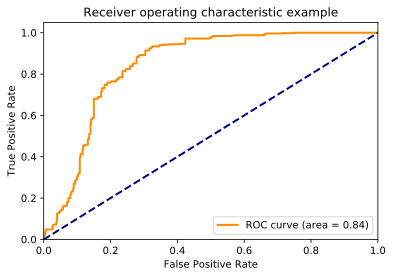

In [16]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [19]:
thresholds = np.arange(1.2,3.0,0.001).tolist()
distances_np = np.array(distances)
labels_np = np.array(labels)
scores = []
tps = []
tns = []
fps = []
fns = []
accs = []
precisions = []
recalls = []
for thresh in thresholds:
    prediction = np.zeros((distances_np.shape[0]))
    prediction[distances_np < thresh] = 1
    score = np.logical_xor(prediction, labels)
    score=np.sum(score)/distances_np.shape[0]
    acc = np.sum(np.logical_xor(prediction, labels)) / prediction.shape[0]
    accs.append(acc)
    precision = np.sum(np.logical_and(prediction, labels))/ (np.sum(np.logical_and(prediction, labels)) + len(np.where((prediction == 1) & (labels_np == 0))[0].tolist()))
    precisions.append(precision)
    recall = np.sum(np.logical_and(prediction, labels)) / (np.sum(np.logical_and(prediction, labels)) + len(np.where((prediction == 0) & (labels_np == 1))[0].tolist()))
    recalls.append(recall)
    if np.sum(prediction) == 0:
        tp = 1
    else:
        tp = np.sum(np.logical_and(prediction, labels)) / np.sum(prediction)
    if len(np.where((prediction == 1) & (labels == 0))[0].tolist())/ np.sum(prediction) == 0:
        tn = 1
    else:
        tn = np.sum(np.logical_and(np.logical_not(prediction), np.logical_not(labels)))
    if np.sum(prediction) == 0:
        fp = 0
    else:
        fp = len(np.where((prediction == 1) & (labels_np == 0))[0].tolist())/ np.sum(prediction)
#     fp = len(np.where((prediction == 1) & (labels == 0))[0].tolist())
    if (prediction.shape[0]-np.sum(prediction,axis=0)) == 0:
        fn = 0
    else:
        fn = len(np.where((prediction == 0) & (labels_np == 1))[0].tolist())/ (prediction.shape[0]-np.sum(prediction,axis=0))
#     fn = len(np.where((prediction == 0) & (labels == 1))[0].tolist())
    scores.append(score)
    tps.append(tp)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
#     print("threshold: {} score: {}".format(thresh, score))

In [51]:
from sklearn.metrics import f1_score
def show_im(target, face_pairs, limit = 20):
    # plot images
    display.set_matplotlib_formats('svg')
    _, figs = plt.subplots(1, min(limit,len(target)), figsize=(20, 10))
    counter = 0
    target = np.random.choice(target, 20)
    for f,face_pair in zip(figs, target):
        if counter >= limit:
            break
        counter += 1
        face1 = cv2.cvtColor(cv2.resize(profiles[face_pairs[face_pair][0]],(64,64)),cv2.COLOR_BGR2RGB)
        face2 = cv2.cvtColor(cv2.resize(cv2.imread(face_pairs[face_pair][1]),(64,64)),cv2.COLOR_BGR2RGB)
        face_pair_output = np.hstack([face1, face2])
        f.imshow(face_pair_output)
        ax = f.axes
        ax.title.set_fontsize(14)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    return
def findSample(target):
    if target[0].shape[0] == 0:
        print("None")
    else:
        show_im(target[0].tolist(), face_pairs)
def predict_threshold(thresh):
    prediction = np.zeros((distances_np.shape[0]))
    prediction[distances_np < thresh] = 1
    fp_index = np.where((prediction == 1) & (labels_np == 0))
    fn_index = np.where((prediction == 0) & (labels_np == 1))
    print("False Postive")
#     findSample(fp_index)
#     print("False Negative")
#     findSample(fn_index)
    
predict_threshold(1.4)

False Postive


In [35]:
import math
def get_values(input_thresh):
    found_index = None
    for i in range (len(thresholds)):
        thresh = thresholds[i]
        if np.absolute(input_thresh - thresh) <= 0.001:
            found_index = i
            break
    if found_index == None:
        print("Error")
        return
    print("Precision: ", precisions[found_index])
    print("Recall: ", recalls[found_index])

In [46]:
get_values(1.4)

Precision:  0.967741935483871
Recall:  0.48


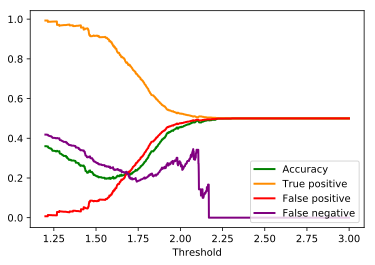

In [21]:
plt.figure()
lw = 2
plt.plot(thresholds, accs, color='green',
         lw=lw, label="Accuracy")
plt.plot(thresholds, tps, color='darkorange',
         lw=lw, label="True positive")
# plt.plot(thresholds, tns, color='green',
#          lw=lw, label="True negative")
plt.plot(thresholds, fps, color='red',
         lw=lw, label="False positive")
plt.plot(thresholds, fns, color='purple',
         lw=lw, label="False negative")
plt.xlabel('Threshold')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

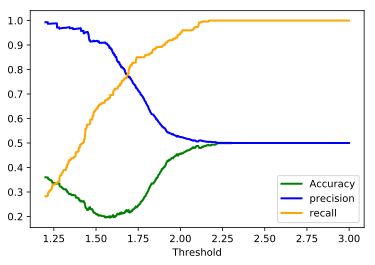

In [22]:
plt.figure()
lw = 2
plt.plot(thresholds, accs, color='green',
         lw=lw, label="Accuracy")
plt.plot(thresholds, precisions, color='blue',
         lw=lw, label="precision")
plt.plot(thresholds, recalls, color='orange',
         lw=lw, label="recall")
plt.xlabel('Threshold')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [277]:
def calc_f1_thresh():
    thresholds = np.arange(1,2,0.1)
    f1s = np.ndarray((thresholds.shape[0]))
    for i in range(thresholds.shape[0]):
        threshold = thresholds[i]
        prediction = np.zeros((distances_np.shape[0]))
        prediction[distances_np < threshold] = 1
        f1 = f1_score(labels, prediction, average='macro')
        f1s[i] = f1
    lw = 2
    plt.plot(thresholds, f1s, color='darkorange',
             lw=lw)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend(loc="lower right")
    plt.show()

No handles with labels found to put in legend.


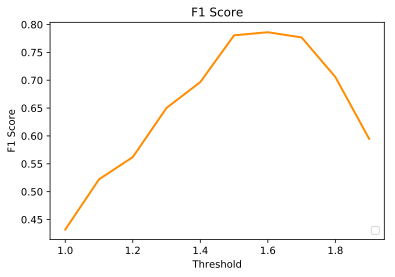

In [278]:
calc_f1_thresh()

In [131]:
target_fps

array([], shape=(0, 1), dtype=int64)